In [2]:
import pandas as pd
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
astro_MG = pd.read_excel('NIHMS739375-supplement-3.xlsx', skiprows=1, index_col=None)
astro_MG.columns = ['gene','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z','AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK']
astro_MG['gene'] = astro_MG['gene'].str.upper().str.strip()
astro_columns = ['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA']
MG_columns = ['AH', 'AI', 'AJ']
astro_MG['avg_astro'] = astro_MG[astro_columns].mean(axis=1)
astro_MG['avg_MG'] = astro_MG[MG_columns].mean(axis=1)
astro_MG = astro_MG[(astro_MG['avg_astro']>1) | (astro_MG['avg_MG']>1)]
astro_MG['astro/MG'] = astro_MG['avg_astro']/astro_MG['avg_MG'] 
# astro_MG['log(astro/MG)'] = astro_MG['astro/MG'].apply(lambda x: math.log(x))
# astro_MG['|log(astro/MG)|'] = astro_MG['log(astro/MG)'].abs()
astro_MG = astro_MG[['gene', 'avg_astro','avg_MG', 'astro/MG']]

/home/nshokran/miniconda3/envs/vae/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
gene_info = pd.read_csv('gene_info.txt', sep='\t')
gene_info.columns = ['0', 'chrom', 'start', 'end', '4', '5', 'gene', '7' ]
gene_info = gene_info.iloc[:,[1,2,3,6]]
gene_info['gene'] = gene_info['gene'].str.upper().str.strip()
result = pd.merge(astro_MG, gene_info,on='gene', how='left')
# result['floored_start'] = result['start'].fillna(-100000).apply(lambda x: math.floor(x / 100000) * 100000)
# result['floored_end'] = result['end'].fillna(-200000).apply(lambda x: math.ciel(x / 100000) * 100000)
# result['gap'] = (result['floored_end']-result['floored_start'])/100000
#result['gap/resolution'] = result['gap'].fillna(-100000).floordiv(100000).astype(int)
# result.to_csv("supplement_with_gene_info.csv")
result = result[result['chrom']=='22']
result['bin_id'] = ((result['start']+result['end'])/200000).astype(int) * 100000

In [8]:
directory = '/project/compbio-lab/scHi-C/Lee2019/results/2023-06-06/Astro_MG_diff/'
intersecs = []
for file_name in os.listdir(directory):
    diff = pd.read_csv(os.path.join(directory, file_name), sep='\t')
    diff = diff[diff['significant']==True]
    intersec = pd.concat([pd.merge(diff,result, left_on='bin1_id',right_on='bin_id'),
                  pd.merge(diff,result, left_on='bin2_id',right_on='bin_id')]).reset_index()
    intersecs.append(intersec)
intersecs = pd.concat(intersecs)
intersecs['gap'] = ((intersecs['bin2_id'] - intersecs['bin1_id'])/100000).astype(int)
gl = 10

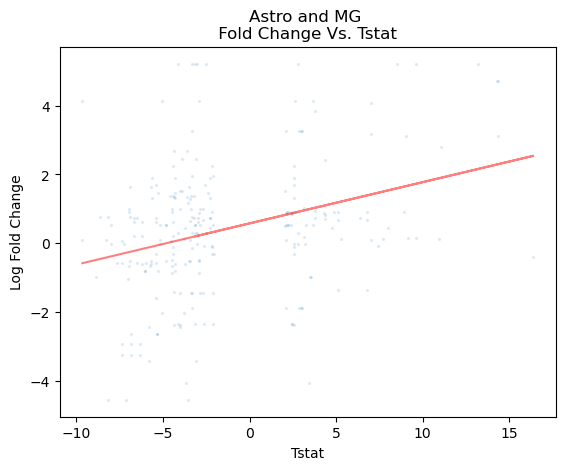

In [9]:
gl = 6
# Plot the scatterplot
plt.scatter(intersecs[intersecs['gap']<gl]['Tstat'], np.log(intersecs[intersecs['gap']<gl]['astro/MG']), alpha=0.1, s=2)

# Calculate the trendline using numpy
slope, intercept = np.polyfit(intersecs[intersecs['gap']<gl]['Tstat'],np.log(intersecs[intersecs['gap']<gl]['astro/MG']), deg=1)
trendline = slope * np.array(intersecs[intersecs['gap']<gl]['Tstat']) + intercept

# Plot the trendline
plt.plot(intersecs[intersecs['gap']<gl]['Tstat'], trendline, color='red', alpha=0.5)

# Add labels and legend
plt.title('Astro and MG \n Fold Change Vs. Tstat ')
plt.ylabel('Log Fold Change')
plt.xlabel('Tstat')

# Show the plot
plt.show()
# result.to_csv("supplement_with_gene_info.csv")

# Save the plot as an image file
#plt.savefig('Astro_MG_Fold_Change_Tstat.png')

In [10]:
print("Slope:", slope)
print("Intercept:", intercept)

# Calculate Pearson correlation coefficient (PCC) and p-value
pcc, p_value = stats.pearsonr(intersecs[intersecs['gap']<gl]['Tstat'], np.log(intersecs[intersecs['gap']<gl]['astro/MG']))

# Print the PCC and p-value
print("Pearson Correlation Coefficient (PCC):", pcc)
print("p-value:", p_value)

Slope: 0.11998057008976612
Intercept: 0.5762024934607705
Pearson Correlation Coefficient (PCC): 0.3134858502157075
p-value: 3.9752654479521396e-07


Text(0, 0.5, 'PCC')

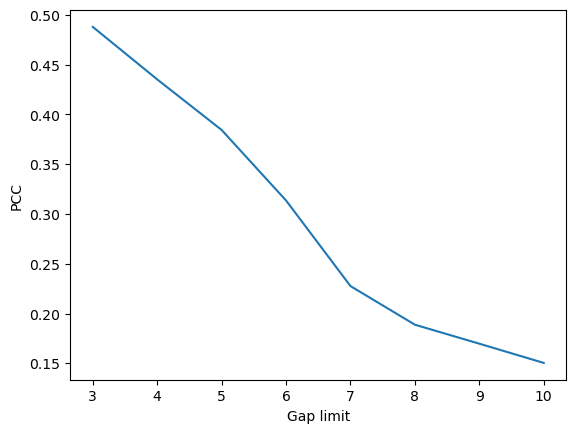

In [11]:
pccs = []
for gl in range(3,11):
    pccs.append(stats.pearsonr(intersecs[intersecs['gap']<gl]['Tstat'], np.log(intersecs[intersecs['gap']<gl]['astro/MG']))[0])
plt.plot(range(3,11), pccs)
plt.xlabel('Gap limit')
plt.ylabel('PCC')